# Chromosome Painting by continent (super-population)

In [1]:
using Revise
using VCFTools
using MendelImpute
using GeneticVariation
using Random
using StatsBase
using CodecZlib
using ProgressMeter
using JLSO
using BenchmarkTools
using GroupSlices
using LinearAlgebra
using DataFrames
using Plots
# using ProfileView

BLAS.set_num_threads(1)

# Download population data

Download [population code](ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000_genomes_project/data/) for each 1000 genomes sample. Different population code is explained [here](https://www.internationalgenome.org/category/population/). 

In [2]:
# run this code in terminal
# wget -r -l3 -N --no-parent ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000_genomes_project/data/

In [2]:
# map population to super-population
pop_to_superpop = Dict{String, String}()

# 5 east asian
pop_to_superpop["CHB"] = "EAS"; pop_to_superpop["JPT"] = "EAS"; pop_to_superpop["CHS"] = "EAS"; 
pop_to_superpop["CDX"] = "EAS"; pop_to_superpop["KHV"] = "EAS"; 

# 5 european
pop_to_superpop["CEU"] = "EUR"; pop_to_superpop["TSI"] = "EUR"; pop_to_superpop["FIN"] = "EUR";
pop_to_superpop["GBR"] = "EUR"; pop_to_superpop["IBS"] = "EAS";

# 7 african
pop_to_superpop["YRI"] = "AFR"; pop_to_superpop["LWK"] = "AFR"; pop_to_superpop["GWD"] = "AFR"; 
pop_to_superpop["MSL"] = "AFR"; pop_to_superpop["ESN"] = "AFR"; pop_to_superpop["ASW"] = "AFR"; 
pop_to_superpop["ACB"] = "AFR"; 

# 4 ad mixed americans
pop_to_superpop["MXL"] = "AMR"; pop_to_superpop["PUR"] = "AMR"; pop_to_superpop["CLM"] = "AMR"; 
pop_to_superpop["PEL"] = "AMR";

# 5 south asian
pop_to_superpop["GIH"] = "SAS"; pop_to_superpop["PJL"] = "SAS"; pop_to_superpop["BEB"] = "SAS"; 
pop_to_superpop["STU"] = "SAS"; pop_to_superpop["ITU"] = "SAS";

# Get each sample's population and super-population origin

In [3]:
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/country_origin")
refID_to_population = Dict{String, String}()
refID_to_superpopulation = Dict{String, String}()
for population in readdir("data/")
    for sample in readdir("data/" * population)
        sample == ".DS_Store" && continue
        refID_to_population[sample] = population
        refID_to_superpopulation[sample] = pop_to_superpop[population]
    end
end
refID_to_superpopulation

Dict{String,String} with 2709 entries:
  "HG01791" => "EUR"
  "HG02736" => "SAS"
  "HG00182" => "EUR"
  "HG03914" => "SAS"
  "HG00149" => "EUR"
  "NA12156" => "EUR"
  "HG02642" => "AFR"
  "HG02851" => "AFR"
  "NA19835" => "AFR"
  "NA19019" => "AFR"
  "HG01131" => "AMR"
  "HG03725" => "SAS"
  "HG03578" => "AFR"
  "NA18550" => "EAS"
  "HG02401" => "EAS"
  "HG01350" => "AMR"
  "HG03973" => "SAS"
  "NA07000" => "EUR"
  "HG01709" => "EAS"
  "HG01395" => "AMR"
  "HG02388" => "EAS"
  "HG01980" => "AMR"
  "HG01979" => "AMR"
  "HG01122" => "AMR"
  "HG03869" => "SAS"
  ⋮         => ⋮

# Compute phase information

In [4]:
# compute each person's phase information
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/filtered")
Random.seed!(2020)
tgtfile = "target.chr18.typedOnly.maf0.1.masked.vcf.gz"
reffile = "ref.chr18.maxd1000.overlap0.0.maf0.1.excludeTarget.jlso"
outfile = "mendel.imputed.jlso"
@time ph = phase(tgtfile, reffile, outfile=outfile);

Number of threads = 8
Importing reference haplotype data...


Computing optimal haplotypes...100%|████████████████████| Time: 0:00:07


Total windows = 2367, averaging ~ 527 unique haplotypes per window.

Timings: 
    Data import                     = 22.8528 seconds
        import target data             = 4.52949 seconds
        import compressed haplotypes   = 18.3234 seconds
    Computing haplotype pair        = 8.29235 seconds
        BLAS3 mul! to get M and N      = 0.317306 seconds per thread
        haplopair search               = 3.65022 seconds per thread
        initializing missing           = 0.0224294 seconds per thread
        allocating and viewing         = 0.0667331 seconds per thread
        index conversion               = 0.00143571 seconds per thread
    Phasing by win-win intersection = 3.27264 seconds
        Window-by-window intersection  = 0.120891 seconds per thread
        Breakpoint search              = 1.84985 seconds per thread
        Recording result               = 0.00245965 seconds per thread
    Imputation                     = 4.0826 seconds
        Imputing missing             

In [5]:
# check ultra-compression matches vcf.gz compression
X_answer = convert_gt(UInt8, "mendel.imputed.vcf.gz", trans=true)
X1, X2, _, _, H = convert_compressed(UInt8, outfile, "ref.chr18.excludeTarget.vcf.gz")
X_phased = X1 + X2
all(X_answer .== X_phased)

importing reference data...100%|████████████████████████| Time: 0:03:59


true

# Compute sample composition in 1000 genomes

In [5]:
# need compressed reference panel
reffile = "ref.chr18.maxd1000.overlap0.0.maf0.1.excludeTarget.jlso"
compressed_Hunique = JLSO.load(reffile)[:compressed_Hunique]
panelID = compressed_Hunique.sampleID

# get sample's ancestry
tgtfile = "target.chr18.typedOnly.maf0.1.masked.vcf.gz"
reader = VCF.Reader(openvcf(tgtfile, "r"))
tgtID  = VCF.header(reader).sampleID
sample_population = [refID_to_population[id] for id in tgtID];
sample_superpopulation = [refID_to_superpopulation[id] for id in tgtID];

In [6]:
findall(x -> x == "CHS", sample_population)

8-element Array{Int64,1}:
  4
  5
  6
  7
  8
  9
 10
 11

  0.099486 seconds (192.80 k allocations: 9.786 MiB)
  0.000167 seconds (5 allocations: 368 bytes)
  0.000254 seconds (5 allocations: 368 bytes)


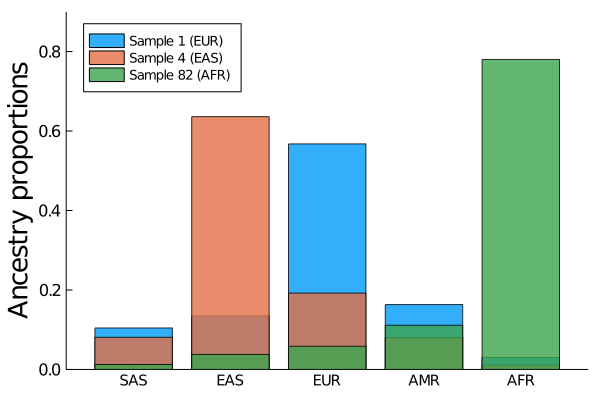

In [7]:
continent = ["SAS", "EAS", "EUR", "AMR", "AFR"]
@time sample1_comp = composition(ph[1], panelID, refID_to_superpopulation, populations=continent)
@time sample4_comp = composition(ph[4], panelID, refID_to_superpopulation, populations=continent)
@time sample82_comp = composition(ph[82], panelID, refID_to_superpopulation, populations=continent)

barplot2 = bar(sample1_comp, xticks=(1:1:5, continent), grid=false, 
    ylabel = "Ancestry proportions", label="Sample 1 (EUR)", alpha=0.8, legend=:topleft,
    xtickfont=font(10), ytickfont=font(11), legendfont=font(9), yguidefontsize=18, 
    ylim=(0, 0.9))
bar!(barplot2, sample4_comp, label="Sample 4 (EAS)", alpha=0.8)
bar!(barplot2, sample82_comp, label="Sample 82 (AFR)", alpha=0.8)

# Try painting an actual chromosome

Generated colors here: https://mdigi.tools/color-shades/#008000 and https://sashamaps.net/docs/resources/20-colors/.

Colors are arranged such that:
+ Blue ≈ European/American
+ Red ≈ Asian
+ Green ≈ African

In [8]:
@time sample1_s1_cont, sample1_s2_cont = paint(ph[1], panelID, refID_to_superpopulation, populations=continent)
@time sample4_s1_cont, sample4_s2_cont = paint(ph[4], panelID, refID_to_superpopulation, populations=continent)
@time sample82_s1_cont, sample82_s2_cont = paint(ph[82], panelID, refID_to_superpopulation, populations=continent);

  0.092045 seconds (117.67 k allocations: 5.956 MiB)
  0.000169 seconds (12 allocations: 29.406 KiB)
  0.000301 seconds (12 allocations: 35.281 KiB)


In [9]:
# super population colors generated here: https://sashamaps.net/docs/resources/20-colors/
# Blue ≈ European, Red = south Asian, Green = African, light blue = american, maroon=east asian
continent_colors = [colorant"#4363d8", colorant"#e6194B", colorant"#bfef45",
    colorant"#42d4f4", colorant"#800000"]

In [10]:
# super-population colors
sample1_s1_cont_colors = [continent_colors[findfirst(x -> x == pop, continent)] for pop in sample1_s1_cont[2]]
sample1_s1_cont_colors = reshape(sample1_s1_cont_colors, 1, length(sample1_s1_cont_colors))

sample1_s2_cont_colors = [continent_colors[findfirst(x -> x == pop, continent)] for pop in sample1_s2_cont[2]]
sample1_s2_cont_colors = reshape(sample1_s2_cont_colors, 1, length(sample1_s2_cont_colors))

sample4_s1_cont_colors = [continent_colors[findfirst(x -> x == pop, continent)] for pop in sample4_s1_cont[2]]
sample4_s1_cont_colors = reshape(sample4_s1_cont_colors, 1, length(sample4_s1_cont_colors))

sample4_s2_cont_colors = [continent_colors[findfirst(x -> x == pop, continent)] for pop in sample4_s2_cont[2]]
sample4_s2_cont_colors = reshape(sample4_s2_cont_colors, 1, length(sample4_s2_cont_colors))

sample82_s1_cont_colors = [continent_colors[findfirst(x -> x == pop, continent)] for pop in sample82_s1_cont[2]]
sample82_s1_cont_colors = reshape(sample82_s1_cont_colors, 1, length(sample82_s1_cont_colors))

sample82_s2_cont_colors = [continent_colors[findfirst(x -> x == pop, continent)] for pop in sample82_s2_cont[2]]
sample82_s2_cont_colors = reshape(sample82_s2_cont_colors, 1, length(sample82_s2_cont_colors));

### By continent

In [ ]:
using StatsPlots, FixedPointNumbers

sample1_s1l = length(sample1_s1_cont[1])
sample1_s2l = length(sample1_s2_cont[1])
sample4_s1l = length(sample4_s1_cont[1])
sample4_s2l = length(sample4_s2_cont[1])
sample82_s1l = length(sample82_s1_cont[1])
sample82_s2l = length(sample82_s2_cont[1])
maxlen = max(sample1_s1l, sample1_s2l, sample4_s1l, sample4_s2l, sample82_s1l, sample82_s2l)

# mylabels = reshape(populations, 1, 26)
mydata = zeros(6, maxlen)
copyto!(@view(mydata[1, 1:sample1_s1l]), sample1_s1_cont[1])
copyto!(@view(mydata[2, 1:sample1_s2l]), sample1_s2_cont[1])
copyto!(@view(mydata[3, 1:sample4_s1l]), sample4_s1_cont[1])
copyto!(@view(mydata[4, 1:sample4_s2l]), sample4_s2_cont[1])
copyto!(@view(mydata[5, 1:sample82_s1l]), sample82_s1_cont[1])
copyto!(@view(mydata[6, 1:sample82_s2l]), sample82_s2_cont[1])

cont_colors = Matrix{RGB{Normed{UInt8,8}}}(undef, 6, maxlen)
copyto!(@view(cont_colors[1, 1:sample1_s1l]), sample1_s1_cont_colors)
copyto!(@view(cont_colors[2, 1:sample1_s2l]), sample1_s2_cont_colors)
copyto!(@view(cont_colors[3, 1:sample4_s1l]), sample4_s1_cont_colors)
copyto!(@view(cont_colors[4, 1:sample4_s2l]), sample4_s2_cont_colors)
copyto!(@view(cont_colors[5, 1:sample82_s1l]), sample82_s1_cont_colors)
copyto!(@view(cont_colors[6, 1:sample82_s2l]), sample82_s2_cont_colors)

xnames = ["Sample 1 hap1", "Sample 1 hap2", "Sample 4 hap1", "Sample 4 hap2", 
        "Sample 82 hap1", "Sample 82 hap2"]
ynames = ["SNP 1", "SNP 212k", "SNP 426k", "SNP 639k", "SNP 852k"]

chrom_plt2 = groupedbar(mydata, bar_position = :stack, bar_width=0.7, label=:none, 
    lw = 0, color=cont_colors, xticks=(1:1:6, xnames), yticks=(0:0.25:1, ynames),
    ytickfont=font(12), xtickfont=font(12), xrotation=20)

In [ ]:
# create a plot for legend
color_x = ones(5)
color_y = collect(1:1:5)
mylegend2 = scatter(color_x, color_y, color=continent_colors, ytick=(1:1:5, continent), 
    xrange=(0.9, 1.1), xtick=false, label=:none, markersize=6, ytickfont=font(12),
    grid=false, framestyle=:grid, mirror=true, tick_direction=:out, markershape=:rect)

In [ ]:
# combine chromosome painting with legend
chrom_plt_with_legend2 = plot(chrom_plt2, mylegend2, layout = grid(1, 2, widths=[0.95, 0.05]))

# Combined all plots

In [27]:
final_plt = plot(barplot, chrom_plt_with_legend, size=(1300, 600), 
    layout = grid(1, 2, widths=[0.5, 0.50]), left_margin = 5Plots.mm)

fontsize=24
annotate!(final_plt, -5.0,  0.31 , text("A", :left, fontsize), subplot=1)
annotate!(final_plt, -1.5,  1.01 , text("B", :left, fontsize), subplot=2)

In [26]:
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/country_origin")
savefig(final_plt, "admixture.png") # remember to set dpi=300